# Generate Distinct Offshore Regions for EBUS Analysis
- This is to maintain consistency in analyzing BGC in EBUS.
- Generally following Turi et al. 2014

In [1]:
import glob

# Numerics
import numpy as np
import pandas as pd
import xarray as xr

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap

In [2]:
def setup_map(ax, lon, lat):
    m = Basemap(projection='eqdc',
                lat_0=np.nanmedian(lat),
                lon_0=np.nanmedian(lon),
                llcrnrlon=np.nanmin(lon),
                urcrnrlon=np.nanmax(lon),
                llcrnrlat=np.nanmin(lat),
                urcrnrlat=np.nanmax(lat),
                resolution='c')
    m.drawcoastlines()
    m.fillcontinents(color='black')
    m.drawmapboundary(fill_color='white')
    m.drawparallels(np.arange(np.floor(np.nanmin(lat)), 
                              np.ceil(np.nanmax(lat)), 3),
                   labels=[True,False,False,False])
    m.drawmeridians(np.arange(np.floor(np.nanmin(lon)), 
                              np.ceil(np.nanmax(lon)), 3),
                   labels=[False, False, False, False])
    return m

In [3]:
def drop_ensemble_dim(x):
    ds[x] = (('nlat', 'nlon'), ds[x][0])
    return ds

In [4]:
# Load in dataset.
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_CO2/'
#fileName = 'FG_CO2.001.CCS.192001-201512.nc'
ds = xr.open_mfdataset(fileDir + "*.nc", concat_dim="ensemble")

In [5]:
# Reduce ensemble dimension for some
ds = drop_ensemble_dim('DXT')
ds = drop_ensemble_dim('TAREA')
ds = drop_ensemble_dim('REGION_MASK')
ds = drop_ensemble_dim('TLAT')
ds = drop_ensemble_dim('TLONG')
del ds['DYT']
del ds['ANGLET']

In [6]:
ds['DXT'] = ds['DXT'] / 100 / 1000 # Convert to km

In [7]:
ds.attrs['DXT units'] = "km"

In [8]:
ds

<xarray.Dataset>
Dimensions:      (ensemble: 34, nlat: 46, nlon: 40, time: 1152)
Coordinates:
  * time         (time) datetime64[ns] 1920-01-31 1920-02-29 1920-03-31 ...
  * nlat         (nlat) int64 265 266 267 268 269 270 271 272 273 274 275 ...
  * nlon         (nlon) int64 226 227 228 229 230 231 232 233 234 235 236 ...
    TLAT         (nlat, nlon) float64 25.14 25.12 25.09 25.07 25.04 25.02 ...
    TLONG        (nlat, nlon) float64 215.0 216.1 217.3 218.4 219.5 220.6 ...
  * ensemble     (ensemble) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
Data variables:
    REGION_MASK  (nlat, nlon) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 ...
    FG_CO2       (ensemble, time, nlat, nlon) float64 -1.122 -1.093 -1.052 ...
    TAREA        (nlat, nlon) float64 6.575e+09 6.563e+09 6.55e+09 6.537e+09 ...
    DXT          (nlat, nlon) float64 113.3 113.3 113.4 113.4 113.4 113.4 ...
Attributes:
    DXT units: km

# Plot the main output domain
- First let's take an unfiltered look at the spatial region

/glade/u/home/rbrady/.local/lib/python2.7/site-packages/dask-0.14.3+38.g522c384-py2.7.egg/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


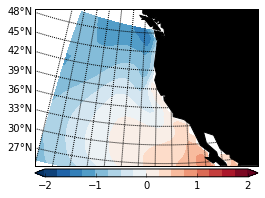

In [9]:
lon = ds['TLONG']
lat = ds['TLAT']
data = ds['FG_CO2'].mean(dim='ensemble').mean(dim='time')

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)
m = setup_map(ax1, lon.values, lat.values)
m.contourf(lon.values, lat.values, data.values, np.arange(-2,2.1,0.25), latlon=True,
          cmap="RdBu_r", extend="both")
m.colorbar(location="bottom", ticks=[-2, -1, 0, 1, 2])

# Filter out the latitude
- Now take out everything south of some location

In [10]:
# Filter the whole dataset to within latitude bands.
ds = ds.where(ds.TLAT > 34).where(ds.TLAT < 44)

# Create a masked array for DXT since it doesn't follow the same NaN structure as co2/region_mask.
co2 = ds['FG_CO2'][0,0]
co2 = np.ma.array(co2, mask=np.isnan(co2))

# Apply mask to DXT and replace in dataset.
dxt_dat = ds['DXT']
dxt_dat = np.ma.array(dxt_dat, mask=np.isnan(co2))
ds['DXT'] = (('nlat', 'nlon'), dxt_dat)

In [11]:
regmask = ds['REGION_MASK']
counter = 0
for row in regmask:
    conditional = 0 in row.values
    if conditional == False:
        ds['DXT'][counter, :] = np.nan            
    counter += 1

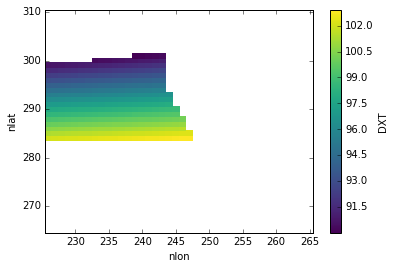

In [12]:
ds['DXT'].plot()

In [13]:
# Now create a cumulative sum of DXTs. Have to use masked array so it doesn't have issues summing nans.
x = ds['DXT'].values
x_masked = np.ma.array(x, mask=np.isnan(x))
dxt_cum = np.cumsum(x_masked[:, ::-1], axis=1)[:, ::-1]
ds['DXT_Cum'] = (('nlat', 'nlon'), dxt_cum)

In [29]:
# Filter to 800km offshore
ds = ds.where(ds['DXT_Cum'] <= 800)

# Plot Study Site

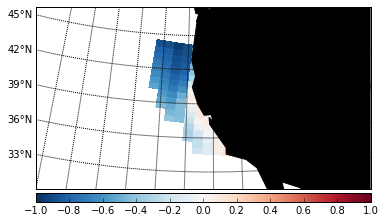

In [31]:
m = Basemap(projection='eqdc',
                lat_0=39,
                lon_0=np.nanmedian(lon),
                llcrnrlon=220,
                urcrnrlon=258,
                llcrnrlat=30,
                urcrnrlat=46,
                resolution='c')
m.drawcoastlines()
m.fillcontinents(color='black')
m.drawmapboundary(fill_color='white')
m.drawparallels(np.arange(30, 46, 3),
                labels=[True, False, False, False])
m.drawmeridians(np.arange(220, 259, 3))

lat = ds['TLAT'].values
lon = ds['TLONG'].values
data = ds['FG_CO2'].mean(dim='time').mean(dim='ensemble')
data = np.ma.array(data, mask=np.isnan(data))
m.pcolormesh(lon, lat, data, vmin=-1, vmax=1, latlon=True,
            cmap="RdBu_r")
m.colorbar(location="bottom")
plt.savefig("calcs-study-site.png")